# Определение возраста покупателей

## Исследовательский анализ данных

In [2]:
import pandas as pd
import numpy as np
import pylab as pl

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing import image

import scipy.stats as stats

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Отображено 5 первых строк датасета. В столбце file_name указаны ID фотографий, в real_age - возраст покупателя на фотографии.

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


([<matplotlib.axis.YTick at 0x7fb93c6fabe0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

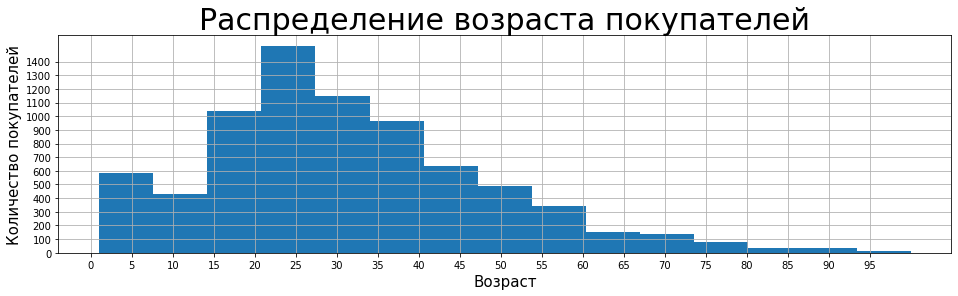

In [7]:
labels.hist(bins = 15, figsize = (16, 4), grid=True)
plt.title("Распределение возраста покупателей", size = 30)
plt.xlabel("Возраст", size = 15)
plt.ylabel("Количество покупателей", size = 15)
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 1500, 100))

<div class="alert alert-block alert-warning">
    
Добавил названия осей, изменил количество bins с 30 ти на 15 - группы стали нагляднее.
    
Установил частоты тиков осей: x - 5 лет, y - 100 покупателей.
 </div>

In [8]:
labels.isna().mean()

file_name    0.0
real_age     0.0
dtype: float64

In [9]:
labels.duplicated().sum()

0

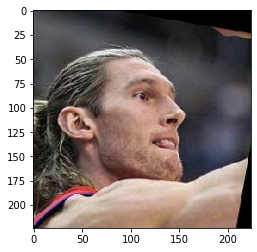

In [10]:
plt.imshow(train_gen_flow[7][0][0])

Вывод:

В датасете 7591 объект с 0 до 7590 и 2 столбца:  file_name и real_age

В столбце file_name указаны ID фотографий, в real_age - возраст покупателя на фотографии.

Признак real_age содержит количественные данные - перед нами стоит задача регрессии.

Средний возраст покупателя равен 31 году, минимальный - 1 год, максимальный - 100 лет. 

Большинство покупателей в возрасте примерно от 15 до 40 лет.

Медиана признака - 29 лет, есть незначительное смещение распределения вправо (средний 31 год.)

Аномалии, пропуски, дубликаты и выбросы отсутствуют.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, 
                steps_per_epoch=None, validation_steps=5):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >


2022-05-07 16:14:33.942097: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-05-07 16:14:33.943798: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-05-07 16:14:34.817903: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-07 16:14:35.508245: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-07 16:14:35.508336: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-07 16:14:35.508369: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-07 16:14:35.510175: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-07 16:14:35.510617: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-05-07 16:14:35.512875: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-05-07 16:14:35.514105: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-05-07 16:14:35.514178: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-05-07 16:14:35.518600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-05-07 16:14:35.518956: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-05-07 16:14:35.526305: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-05-07 16:14:35.526908: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5dde350 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-07 16:14:35.526942: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-07 16:14:35.674656: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5e64370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-05-07 16:14:35.674710: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-05-07 16:14:35.677540: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-07 16:14:35.677637: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-07 16:14:35.677656: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-07 16:14:35.677713: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-07 16:14:35.677735: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-05-07 16:14:35.677754: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-05-07 16:14:35.677771: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-05-07 16:14:35.677784: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-05-07 16:14:35.682936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-05-07 16:14:35.683038: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-07 16:14:36.013533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-05-07 16:14:36.013593: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-05-07 16:14:36.013603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-05-07 16:14:36.018241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 5 steps
Epoch 1/10
2022-05-07 16:14:46.937225: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-07 16:14:47.261717: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 39s - loss: 207.7901 - mae: 10.9374 - val_loss: 342.9827 - val_mae: 12.8324
Epoch 2/10
2022-05-07 16:15:49.671734: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 140.0684 - mae: 9.1014 - val_loss: 315.6533 - val_mae: 12.7952
Epoch 3/10
2022-05-07 16:16:19.322469: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 110.7943 - mae: 8.0318 - val_loss: 157.3766 - val_mae: 10.2374
Epoch 4/10
2022-05-07 16:16:48.883909: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 91.7158 - mae: 7.3633 - val_loss: 118.9516 - val_mae: 8.4000
Epoch 5/10
2022-05-07 16:17:18.470846: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 81.8054 - mae: 6.8710 - val_loss: 111.4641 - val_mae: 8.1658
Epoch 6/10
2022-05-07 16:17:47.850735: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 29s - loss: 66.9872 - mae: 6.2789 - val_loss: 80.5679 - val_mae: 6.3735
Epoch 7/10
2022-05-07 16:18:17.522993: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 56.9462 - mae: 5.7582 - val_loss: 143.7631 - val_mae: 8.8063
Epoch 8/10
2022-05-07 16:18:47.587892: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 48.5137 - mae: 5.3971 - val_loss: 73.5741 - val_mae: 6.7104
Epoch 9/10
2022-05-07 16:19:17.442290: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 41.9054 - mae: 4.9762 - val_loss: 76.8642 - val_mae: 6.9670
Epoch 10/10
2022-05-07 16:19:47.228318: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 35.3935 - mae: 4.5972 - val_loss: 80.0612 - val_mae: 6.6025
2022-05-07 16:19:47.752115: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 109.6772 - mae: 7.7775
Test MAE: 7.7775
2022-05-07 16:14:33.942097: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-05-07 16:14:33.943798: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-05-07 16:14:34.817903: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-07 16:14:35.508245: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-07 16:14:35.508336: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-07 16:14:35.508369: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-07 16:14:35.510175: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-07 16:14:35.510617: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-05-07 16:14:35.512875: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-05-07 16:14:35.514105: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-05-07 16:14:35.514178: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-05-07 16:14:35.518600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-05-07 16:14:35.518956: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-05-07 16:14:35.526305: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-05-07 16:14:35.526908: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5dde350 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-07 16:14:35.526942: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-07 16:14:35.674656: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5e64370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-05-07 16:14:35.674710: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-05-07 16:14:35.677540: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-07 16:14:35.677637: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-07 16:14:35.677656: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-07 16:14:35.677713: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-07 16:14:35.677735: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-05-07 16:14:35.677754: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-05-07 16:14:35.677771: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-05-07 16:14:35.677784: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-05-07 16:14:35.682936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-05-07 16:14:35.683038: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-07 16:14:36.013533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-05-07 16:14:36.013593: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-05-07 16:14:36.013603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-05-07 16:14:36.018241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 5 steps
Epoch 1/10
2022-05-07 16:14:46.937225: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-07 16:14:47.261717: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 39s - loss: 207.7901 - mae: 10.9374 - val_loss: 342.9827 - val_mae: 12.8324
Epoch 2/10
2022-05-07 16:15:49.671734: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 140.0684 - mae: 9.1014 - val_loss: 315.6533 - val_mae: 12.7952
Epoch 3/10
2022-05-07 16:16:19.322469: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 110.7943 - mae: 8.0318 - val_loss: 157.3766 - val_mae: 10.2374
Epoch 4/10
2022-05-07 16:16:48.883909: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 91.7158 - mae: 7.3633 - val_loss: 118.9516 - val_mae: 8.4000
Epoch 5/10
2022-05-07 16:17:18.470846: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 81.8054 - mae: 6.8710 - val_loss: 111.4641 - val_mae: 8.1658
Epoch 6/10
2022-05-07 16:17:47.850735: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 29s - loss: 66.9872 - mae: 6.2789 - val_loss: 80.5679 - val_mae: 6.3735
Epoch 7/10
2022-05-07 16:18:17.522993: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 56.9462 - mae: 5.7582 - val_loss: 143.7631 - val_mae: 8.8063
Epoch 8/10
2022-05-07 16:18:47.587892: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 48.5137 - mae: 5.3971 - val_loss: 73.5741 - val_mae: 6.7104
Epoch 9/10
2022-05-07 16:19:17.442290: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 41.9054 - mae: 4.9762 - val_loss: 76.8642 - val_mae: 6.9670
Epoch 10/10
2022-05-07 16:19:47.228318: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
356/356 - 30s - loss: 35.3935 - mae: 4.5972 - val_loss: 80.0612 - val_mae: 6.6025
2022-05-07 16:19:47.752115: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 109.6772 - mae: 7.7775
Test MAE: 7.7775



```

## Анализ обученной модели

В ходе обучения модели применена архитектура ResNet.  

Оценка качества модели проведена метрикой MAE.

Подбором значений аргументов удалось получить модель MAE = 7,78:

- размер шага learning rate алгоритма Adam lr=0.0005
- размер батча batch_size - количество образцов на обновление градиента = 10

Проверено множество вариантов, думаю возможно улучшение качества модели.